# The complete training and evaluation process with PyTorch

## 學習目標
- 我們已經學過 Gradient Descent, Backpropagation, 以及更進階的梯度下降最佳化方法 (如 SGD, Adam 等)
- 因此我們接下來要實作一個完整的神經網路訓練流程，同時也將介紹評估流程

## 測試現在這個 Colab 環境是否已經使用 GPU
- 否則等下可能會需要重新啟動 Colab 環境

In [ ]:
import torch
torch.cuda.is_available() # 結果需要顯示為 True

True

## PyTorch 常用套件

| 套件名稱 | 主要內容 |
|-|-|
|[`torch.nn as nn`](https://pytorch.org/docs/stable/nn.html) | 與模型架構相關的函數，包含各種層與目標函數的實作 |
|[`torch.optim`](https://pytorch.org/docs/stable/optim.html) | 與模型最佳化有相關的函數 (optim: optimization) |
|[`torchvision`](https://pytorch.org/vision/stable/index.html) | 與電腦視覺 (影像) 任務有相關的函數 |
|[`torchvision.transforms`](https://pytorch.org/vision/0.9/transforms.html) | 幫助進行影像資料前處理的函數 |

In [ ]:
# 引入本教學所需要的套件

import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tqdm import tqdm

## 載入資料
- 本教學使用的是 MNIST 手寫字辨識資料集 (by [Yann LeCun](http://yann.lecun.com/exdb/mnist/))

![MNIST](https://upload.wikimedia.org/wikipedia/commons/b/b1/MNIST_dataset_example.png)

## 觀察資料

In [ ]:
# 載入 MNIST 資料
# `train=False` 代表載入 test 資料
tmp = torchvision.datasets.MNIST(root="./data", train=False, download=True)

# 取得第一張圖片和標籤
image, label = tmp[0]
print(f"image 的資料格式為: {type(image)}")

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.3MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 492kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.54MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.19MB/s]

image 的資料格式為: <class 'PIL.Image.Image'>


In [ ]:
# Jupyter Notebook 內建支援顯示 PIL 影像
# 所以直接輸入在程式格中執行後會自動顯示原始影像

image

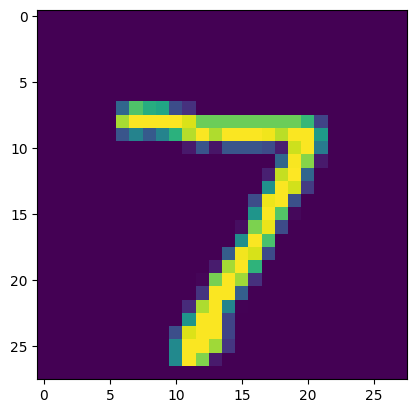

In [ ]:
# maplotlib 的 imshow 功能可以顯示 PIL 影像
# 但如果是灰階影像的話，它會幫套上 colormap，所以看起來很像彩色影像

plt.imshow(image)
# plt.imshow(image, cmap="gray") # 若資料是灰階影像，應加上 cmap="gray"

In [ ]:
# 觀察有進行 ToTensor() 後的資料
transform = transforms.Compose(
    [
        transforms.ToTensor(),
    ]
)
trainset = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform,
)

# 取得第一張圖片和標籤
image, label = trainset[0]
print(f"image 的資料格式為: {type(image)}")

image 的資料格式為: <class 'torch.Tensor'>


In [ ]:
image.shape

torch.Size([1, 28, 28])

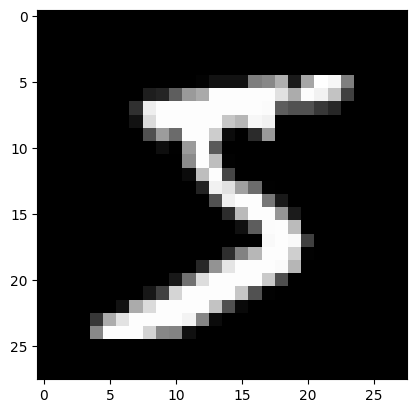

In [ ]:
plt.imshow(image.squeeze(), cmap="gray")

## 建立模型

In [ ]:
MODEL_NAME = "resnet-18" # or "resnet-18

In [ ]:
# 定義 MLP 模型
class MLP(nn.Module):
    def __init__(self):
        super().__init__() # 繼承 nn.Module 類別的初始化函數
        hidden_size1 = 256 # 第一層隱藏層的神經元數量
        hidden_size2 = 128 # 第二層隱藏層的神經元數量

        self.layer_1 = nn.Linear(28*28, hidden_size1)
        self.layer_2 = nn.Linear(256, hidden_size2)
        self.relu = nn.ReLU() # 非線性轉換
        self.cls_layer = nn.Linear(hidden_size2, 10)

    def forward(self, x):
        x = x.view(-1, 28*28) # 將輸入的 x 轉為 28*28 的形狀 (因為 transform.ToTensor() 會把圖片轉為 1*28*28)
        x = self.relu(self.layer_1(x))
        x = self.relu(self.layer_2(x))
        x = self.cls_layer(x)
        return x

In [ ]:
# 初始化模型

if MODEL_NAME == "resnet-18":
    model = torchvision.models.resnet18(pretrained=True)
    model.fc = nn.Linear(512, 10)
elif MODEL_NAME == "MLP":
    model = MLP()
else:
    raise NotImplementedError

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 139MB/s]


In [ ]:
# 載入 MNIST 資料並進行影像前處理
# PyTorch 官方範例連結：https://github.com/pytorch/examples/blob/main/mnist_forward_forward/main.py#L160C23-L160C43

# 資料前處理管線
if MODEL_NAME == "resnet-18":
    transform = transforms.Compose(
        [
            transforms.Resize((224, 224)),
            transforms.Grayscale(num_output_channels=3),  # 把 1-channel 轉成 3-channel
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    )
elif MODEL_NAME == "MLP":
    transform = transforms.Compose([transforms.ToTensor(),])
else:
    raise NotImplementedError


# 載入 MNIST 資料
# `train=False` 代表載入 test 資料
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

In [ ]:
print(f"MNIST 訓練資料有 {len(trainset)} 筆")
print(f"MNIST 測試資料有 {len(testset)} 筆")

MNIST 訓練資料有 60000 筆
MNIST 測試資料有 10000 筆


## 將資料分裝成 batches
- 假設我們有一個資料集，進行機器學習時，我們會將資料分為：
    - **訓練資料 (training data)**：用來訓練模型
    - **驗證資料 (validation data)**：在訓練訓練階段，我們可能訓練了多個模型，要知道哪個模型是最好的則需要對模型進行測試，在模型訓練階段用以測試模型的資料我們稱為「驗證資料」
    - **測試資料 (test data)**：完成模型訓練後，用來檢視模型真正成效的資料
- 一般來說，我們會將訓練資料打亂 (`shuffle=True`)，驗證/測試資料不打亂
- 我們可以使用 Scikit-learn 的 [`train_test_split`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) 來進行資料切分

In [ ]:
# 把 validation set 從 training set 切出來 10%
# random_state: Pass an int for reproducible output

N = len(trainset)
indices = torch.arange(N)

train_idx, val_idx = train_test_split(
    indices.numpy(),
    test_size=0.1,
    random_state=42,
)

trainset_sub = torch.utils.data.Subset(trainset, train_idx)
valset   = torch.utils.data.Subset(trainset, val_idx)

In [ ]:
print(f"MNIST 訓練資料有 {len(trainset)} 筆")
print(f"MNIST 訓練資料有 {len(valset)} 筆")
print(f"MNIST 測試資料有 {len(testset)} 筆")

MNIST 訓練資料有 60000 筆
MNIST 訓練資料有 6000 筆
MNIST 測試資料有 10000 筆


In [ ]:
train_loader = torch.utils.data.DataLoader(
    trainset_sub,
    batch_size=64,
    shuffle=True,
)
val_loader = torch.utils.data.DataLoader(
    valset,
    batch_size=256,
    shuffle=False,
)
test_loader = torch.utils.data.DataLoader(
    testset,
    batch_size=256,
    shuffle=False,
)

## 取得 DataLoader 中的一個 Batch
- 在 PyTorch 中，`DataLoader` 是一個 **可迭代對象 (iterable)**
- 我們可以使用 **`iter()`** 和 **`next()`** 來手動取得一個 batch：
```python
images, labels = next(iter(train_loader))
```

In [ ]:
# 觀察 batches 資料

train_iter = iter(train_loader)  # 取得迭代器
batch_x, batch_y = next(train_iter) # 取出一個 batch
print(batch_x)
print(batch_y)
print(batch_x.shape)
print(batch_y.shape)

tensor([[[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],

         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],

         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]],


        [[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1.

In [ ]:
# 每次進行 next() 就會取得下一次的迭代

_, batch_y = next(train_iter) # 這邊就單純觀察 y 就好
print(batch_y)
print(batch_y.shape)

tensor([2, 6, 3, 2, 9, 7, 1, 3, 5, 9, 8, 9, 8, 9, 8, 3, 6, 5, 1, 8, 7, 9, 6, 3,
        5, 8, 2, 4, 0, 4, 8, 4, 7, 7, 6, 6, 7, 2, 1, 5, 0, 8, 8, 0, 4, 5, 4, 3,
        4, 7, 3, 4, 7, 1, 2, 8, 7, 6, 9, 8, 4, 1, 0, 5])
torch.Size([64])


## Helper functions

In [ ]:
def train_epoch(
    model: nn.Module,
    data_loader: torch.utils.data.DataLoader,
    optimizer: torch.optim.Optimizer,
    loss_fn: torch.nn.Module,
    device: torch.device,
):
    """
    執行一個訓練 epoch 的函式
    """
    model.train() # 確保 model 是在訓練模式
    total_loss = 0 # 紀錄 loss 數值

    progress_bar = tqdm(data_loader, desc="Training")
    for batch in progress_bar:
        # 把資料移動到 GPU
        images, labels = batch[0].to(device), batch[1].to(device)

        optimizer.zero_grad()

        # 1. 前向傳播
        outputs = model(images)
        loss = loss_fn(outputs, labels)

        # 2. 反向傳播 (計算梯度)
        loss.backward()

        # 3. 更新模型權重
        optimizer.step()

        # 儲存 loss 數值
        total_loss += loss.item()

        progress_bar.set_postfix({
            'loss': f"{total_loss / (progress_bar.n + 1):.4f}",
        })
    return total_loss / len(data_loader) # 回傳平均每筆資料的 loss

### 計算分數
- 我們可以使用 Scikit-learn 的 [`accuracy_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) 來幫我們計算準確率 (Accuracy)：
```python
sklearn.metrics.accuracy_score(y_true, y_pred, *, normalize=True, sample_weight=None)
```

In [ ]:
def do_eval(
    model: nn.Module,
    data_loader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    device: torch.device,
):
    """
    執行一個評估 epoch 的函式
    """
    model.eval() # 確保 model 是在評估模式
    total_loss = 0 # 紀錄 loss 數值
    label_list = []
    prediction_list = []

    progress_bar = tqdm(data_loader, desc="Evaluating")
    with torch.no_grad():
        for batch in progress_bar:
            images, labels = batch[0].to(device), batch[1].to(device)
            outputs = model(images) # `outputs` 的形狀是 (batch_size, 10)
            # print(outputs.shape)
            loss = loss_fn(outputs, labels)
            total_loss += loss.item()

            prediction = outputs.argmax(dim=1) # `prediction` 的型態是 tensor

            # 我們希望 `predictions` 的長相是 [1, 2, 0, 4, 5, 7, ...]
            # 如果用 append 的話可能會變成 [[1, 2, 0], [4, 5, 7], ...]
            prediction_list.extend(prediction.tolist())

            label_list.extend(labels.tolist())

    avg_loss = total_loss / len(data_loader)
    accuracy = accuracy_score(label_list, prediction_list)
    return avg_loss, accuracy, label_list, prediction_list

## 訓練模型

In [ ]:
# 設定設備
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# 初始化模型、損失函數、optimizer

model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# 訓練模型

epochs = 10 # MLP 可以訓練久一點，ResNet-18 只需要 1 個 epoch就夠了
train_losses, val_losses = [], []

for epoch in range(epochs):
    train_loss_epoch = train_epoch(
        model=model,
        data_loader=train_loader,
        optimizer=optimizer,
        loss_fn=criterion,
        device=device,
    )
    train_losses.append(train_loss_epoch)

    # 驗證模型
    val_loss, val_acc, _, _ = do_eval(
        model=model,
        data_loader=val_loader,
        loss_fn=criterion,
        device=device,
    )
    val_losses.append(val_loss)

    print()
    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss_epoch:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

Evaluating: 100%|██████████| 24/24 [00:17<00:00,  1.41it/s]



Epoch 1/10 | Train Loss: 0.0685 | Val Loss: 0.0718 | Val Acc: 0.9788


Training:   5%|▌         | 46/844 [00:14<04:05,  3.25it/s, loss=0.0261]


KeyboardInterrupt: 

## 測試訓練完的模型

In [ ]:
# 測試訓練完的模型
test_loss, test_acc, _, _ = do_eval(
    model=model,
    data_loader=test_loader,
    loss_fn=criterion,
    device=device,
)
print()
print(f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}")

In [ ]:
def plot_loss_history(train_losses: list, val_losses: list):
    """
    繪製訓練過程的 Training Loss 和 Validation Loss 曲線。

    Args:
        train_losses (list): 訓練集的 loss 歷史記錄。
        val_losses (list): 驗證集的 loss 歷史記錄。
    """
    # 繪製 loss 的歷史記錄圖
    plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
    plt.plot(range(1, epochs+1), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.xlim([1, epochs])
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()

plot_loss_history(train_losses, val_losses)